## Imports

In [12]:
import pickle
from multiprocessing import Pool

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, MaxNLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib import gridspec

import GPy as gpy
import emcee

# matplotlib style sheet
plt.style.use('../../neutron_stars_tf/etf/style_1.mplstyle')

# Seed
np.random.seed(100)

## Setup

In [13]:
# Text box properties
text_bbox = dict(boxstyle='round',
                 facecolor=(1, 1, 1, 1),
                 edgecolor='k',
                 pad=0.5)

# Load data

In [2]:
columnHeadings = ['col1',
                  'N_Z', 'N', 'Z', 'A', 'El',
                  'origin',
                  'mass_excess', 'mass_excess_unc',
                  'BE_A', 'BE_A_unc',
                  'B', 'beta_decay', 'beta_decay_unc',
                  'atomic_mass_1', 'atomic_mass_2', # digits pre- and post- decimal point are in separate columns
                  'atomic_mass_unc']

# Width of each column in AME data file
AMEwidths = [1, 3, 5, 5, 5, 4, 4, 14, 11, 11, 9, 3, 11, 9, 4, 13, 11]

experimental = pd.read_fwf('mass16.txt', widths=AMEwidths,
                 names=columnHeadings, skiprows=39)

# Clean and separate data

In [3]:
# Keep only nuclide and binding energy info
experimental = experimental[['N', 'Z', 'A', 'El', 'BE_A', 'BE_A_unc']]

# Mass values that are not purely experimental have a '#'
experimental['estimated'] = experimental['BE_A'].str.contains('#')

# Remove '#' and convert BE_A and BE_A unc. to floats
experimental[['BE_A', 'BE_A_unc']] = experimental[['BE_A', 'BE_A_unc']].replace('#', '', regex=True)
experimental = experimental.astype({'BE_A': 'float64', 'BE_A_unc': 'float64'})

# Convert to MeV
experimental.loc[:,['BE_A', 'BE_A_unc']] /= 1000.

# Total BE and experimental errors
experimental['BE'] = experimental.BE_A * experimental.A
experimental['BE_unc'] = experimental.BE_A_unc * experimental.A

# Load DZ residuals

In [4]:
# DZwidths = [12, 12, 12, 26]
# DZres = pd.read_fwf('DZ_residuals.dat', widths=DZwidths,
#             names=['A', 'N', 'Z', 'residual'], skiprows=1)

# # Check that all DZ residuals are for measured nuclei
# numDZres_measured = len(DZres[['N', 'Z']].merge(measured[['N', 'Z']], how='inner'))
# print(f'Total DZ residuals = {len(DZres)}')
# print(f'DZ residuals for measured nuclei = {numDZres_measured}')

# More complete DZ mass table
DZwidths = [12, 12, 21]
DZres = pd.read_fwf('dzcode/MassTableDZ.dat', widths=DZwidths,
                    names=['Z', 'N', 'BE_DZ'], skiprows=1)

# BE/A for DZ model
DZres['BE_A_DZ'] = DZres.BE_DZ / (DZres.N + DZres.Z)

# Merge experimental and DZ data, re-order columns, sort by Z then N, complete A columnb
DZres = DZres.merge(experimental, how='outer', on=['Z', 'N'])
DZres = DZres.reindex(columns=['Z', 'N', 'A', 'El', 'BE', 'BE_unc', 'BE_A', 'BE_A_unc', 'estimated',
                               'BE_DZ', 'BE_A_DZ'])
DZres = DZres.sort_values(by=['Z', 'N'])
DZres.A = DZres.Z + DZres.N

# List of all Z values
ZList = DZres.Z.unique()
# Make element list from (row 0, column 3) of all entries where El is not NaN, for specified Z
ElList = [DZres[(DZres.El.notna()) & (DZres.Z == Z)].iloc[0,3] for Z in ZList]
ElDict = dict(zip(ZList, ElList))
# Use dictionary to fill in blank values for El
DZres.El = DZres.Z.map(ElDict)

# Calculate residuals
DZres['BE_residual'] = DZres.BE_DZ - DZres.BE

# Train GP on DZ residuals

## Prepare training and testing data

In [5]:
# Select all or subset of residuals for training GP
Zmin, Zmax = 0, 120
query = f'Z >= {Zmin} & Z <= {Zmax} & BE_DZ.notna()'

train = DZres.query(query)
train = train[train.estimated.eq(False)]
train.to_pickle('GP_training/train.pkl')

# Average error of experimental BEs
trainErrorsMean = train.BE_unc.mean()
print(f'Mean experimental error: {trainErrorsMean}')

Xtrain = train[['N', 'Z']].to_numpy()
Ytrain = np.atleast_2d(train.BE_residual.to_numpy()).T

Mean experimental error: 0.029087537800687287


In [6]:
# Select estimated values (in Z range) for testing
test = DZres.query(query)
test = test[test.estimated.eq(True)]
test.to_pickle('GP_training/test.pkl')

Xtest = train[['N', 'Z']].to_numpy()
Ytest = np.atleast_2d(train.BE_residual.to_numpy()).T

## Model setup

In [7]:
# Create 2D RBF kernel, with ARD
kernel = gpy.kern.RBF(input_dim=2, ARD=True)

# Create GPy model
model = gpy.models.GPRegression(Xtrain, Ytrain, kernel=kernel, noise_var=trainErrorsMean**2)
# # Fix GP noise parameter to average scale of experimental uncertainty
# model.Gaussian_noise.variance.fix()
print(f'Initial model parameters: {model.param_array}')

# First optimise using MLE to get good starting point for HMC
model.optimize_restarts(num_restarts=4, messages=True, clear_after_finish=True)

# Save model and print some info
with open('GP_training/model.pkl', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

print(f'RBF variance after MLE optimisation: {model.rbf.param_array[0]}')
print(f'RBF lengthscales after MLE optimisation: {model.rbf.param_array[1:]}')
print(f'Nugget sigma: {np.sqrt(model.param_array[3])}')

Initial model parameters: [1.         1.         1.         0.00105124]


Optimization restart 1/4, f = 100.93420486299408


Optimization restart 2/4, f = 100.93420486123148


Optimization restart 3/4, f = 100.93420486096522


Optimization restart 4/4, f = 100.93420486106754
RBF variance after MLE optimisation: 0.6399035919534561
RBF lengthscales after MLE optimisation: [2.94166543 2.54322855]
Nugget sigma: 0.20679383675463348


# Predictions with DZ+GP

## Selected chains

In [7]:
def predictResiduals(model, XPred):
    # GP predictions at unknown points
    meanNew, covNew = model.predict_noiseless(XPred)

    # Save to file
    np.savetxt('GP_training/GP_predictions.dat',
               np.hstack((XPred, meanNew, covNew)),
               fmt=('\t%d', '\t%d', '\t%.9e', '\t%.9e'),
               header='\tN\tZ\tmeans\t\t\t\tcovs')
    
    return meanNew, covNew

with open('GP_training/model.pkl', 'rb') as f:
    model = pickle.load(f)

pred = DZres.query(query)
pred = pred[pred.estimated.notna()]
XPred = pred[['N', 'Z']].to_numpy()
means, covs = predictResiduals(model, XPred)
pred['GP_mean'] = means
pred['GP_sigma'] = np.sqrt(covs)
pred['DZ_GP'] = pred.BE_residual - pred.GP_mean
pred.to_pickle('GP_training/predict.pkl')

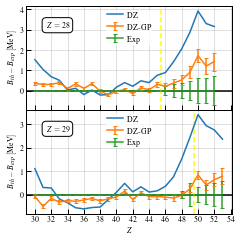

In [26]:
# Plot
Zvals = [28, 29]
vertLinePos = [45.5, 49.5]

fig, axs = plt.subplots(len(Zvals), 1, figsize=(3.4, 3.4), sharex=True, gridspec_kw={'hspace': 0.})

for i, (ax, Z, v) in enumerate(zip(axs, Zvals, vertLinePos)):
    chain = pred.query('Z == @Z & N >= 30')
    
    ax.axhline(0., c='k')
    ax.axvline(v, ls='--', c='yellow')
    
    ax.plot(chain.N, chain.BE_residual, label='DZ')
    ax.errorbar(chain.N, chain.DZ_GP, yerr=chain.GP_sigma,
                capsize=2., label='DZ-GP')
    ax.errorbar(chain.N, np.zeros(len(chain.N)), yerr=chain.BE_unc,
                capsize=2., label='Exp')
    
    ax.text(0.1, 0.8, fr'$Z={Z}$',
            bbox=text_bbox,
            transform=ax.transAxes)
    
    ax.set_ylabel(r'$B_{th}-B_{exp}\left[\mathrm{MeV}\right]$')
    
    ax.xaxis.set_major_locator(MultipleLocator(2))
    
    ax.legend(loc='upper center')

axs[-1].set_xlabel('$Z$')
fig.align_ylabels(axs[:])

fig.tight_layout()
fig.savefig('GP_training/Z_chains.pdf')

## Residuals as function of $A$

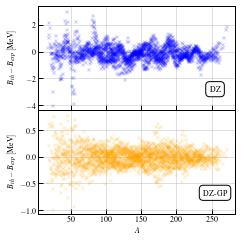

In [27]:
fig, axs = plt.subplots(2, 1, figsize=(3.4, 3.4), sharex=True, gridspec_kw={'hspace': 0.})

text = ['DZ', 'DZ-GP']

axs[0].plot(train.A, train.BE_residual,
            c='blue', ls='', marker='x', alpha=0.2)
axs[1].plot(pred[pred.estimated == False].A, pred[pred.estimated == False].DZ_GP,
            c='orange', ls='', marker='x', alpha=0.2)

axs[1].set_xlabel(r'$A$')

for ax, t in zip(axs, text):
    ax.set_ylabel(r'$B_{th}-B_{exp}\left[\mathrm{MeV}\right]$')
    ax.text(0.9, 0.2, t,
            ha='center', va='center',
            bbox=text_bbox,
            transform=ax.transAxes)

fig.align_ylabels(axs[:])

fig.tight_layout()
fig.savefig('GP_training/residuals_vs_A.pdf')

## Comparing residual distributions

sigma for DZ for training data: 0.591 MeV
sigma for DZ-GP for training data: 0.175 MeV


,Z,N,A,BE,BE_unc,BE_A,BE_A_unc,BE_DZ,BE_A_DZ,BE_residual,GP_mean,GP_sigma,DZ_GP
count,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000
mean,58.273625,81.629725,139.903351,1124.900112,0.029088,8.159786,0.000350,1124.814876,8.159135,-0.085235,-0.084849,0.087694,-0.000387
std,23.907182,36.671463,60.151425,444.276506,0.092694,0.371506,0.001535,444.246937,0.372573,0.591347,0.550679,0.013345,0.175402
min,8.000000,8.000000,16.000000,127.619296,0.000000,6.444031,0.000000,127.966916,6.436802,-4.003566,-3.082066,0.081370,-0.980462
25%,40.000000,53.000000,93.750000,800.388670,0.001907,7.869458,0.000016,800.183864,7.871305,-0.427811,-0.407775,0.081480,-0.105594
50%,59.000000,82.000000,141.000000,1164.275899,0.006881,8.206324,0.000050,1164.337216,8.205291,-0.101915,-0.092512,0.082058,0.001447
75%,79.000000,109.000000,188.000000,1481.069887,0.018844,8.466148,0.000125,1481.587240,8.466495,0.244233,0.227371,0.085935,0.104551
max,110.000000,160.000000,270.000000,1958.519250,1.336650,8.794553,0.023008,1960.450142,8.795034,3.036350,2.517734,0.176573,0.787772


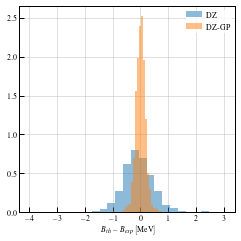

In [28]:
print(f'sigma for DZ for training data: {train.BE_residual.std():.3f} MeV')
print(f'sigma for DZ-GP for training data: {pred[pred.estimated == False].DZ_GP.std():.3f} MeV')

fig, ax = plt.subplots(1, 1, figsize=(3.4, 3.4))

ax.hist(train.BE_residual, bins=25, density=True,
        label='DZ',
        alpha=0.5)
ax.hist(pred[pred.estimated == False].DZ_GP, bins=25, density=True,
        label='DZ-GP',
        alpha=0.5)

ax.set_xlabel(r'$B_{th}-B_{exp}\left[\mathrm{MeV}\right]$')

ax.legend()
fig.tight_layout()

fig.savefig('GP_training/residualDists.pdf')

pred[pred.estimated == False].describe()

# MCMC inference

## Walker start positions

In [ ]:
# MCMC Options
nwalkers = 40
nchain = 2000

# RBF variance and lengthscales from ML optimisation
x0 = model.rbf.param_array

# Number of parameters
ndim = x0.shape[0]

print(f'Dimensions = {ndim}')
print(f'Walkers = {nwalkers}')
print(f'Chain length = {nchain}')
print(f'Function calls = {nwalkers*nchain}')

# Initialise walkers in 'small Gaussian ball' around minimum
p0 = x0 + 1e-5 * np.random.randn(nwalkers, ndim)

## Sample

In [ ]:
# # Log-probability function
# def log_prob(p, model, noise):
#     if any(p <= 0.):
#         return -np.inf
        
#     else:
#         model[''] = list(p) + [noise]
#         return model.log_likelihood()

# # Enable (shared-memory) parallelisation
# with Pool() as pool:
#     # Create sampler
#     sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(model, trainErrorsMean), pool=pool)
    
#     # Run sampler with progress bar
#     sampler.run_mcmc(p0, nchain, progress=True)

# # Autocorrelation time
# tau = sampler.get_autocorr_time()

# # Number of samples to discard from beginning of chain
# burnin = int(2 * np.max(tau))

# # How much to thin chain
# thin = int(0.5 * np.min(tau))

# print(f'tau = {tau}')
# print(f'Burn-in = {burnin}')
# print(f'Thin = {thin}')

# # 3D array of samples
# samples = sampler.get_chain()

# # Save all samples for reuse
# np.save('samples', samples)

# # Remove 'burn-in' samples, and thin samples so not too many correlated samples are plotted
# flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)

# # Save modified samples for plotting again
# np.savetxt('flat_samples.dat', flat_samples)

# # Extract log probabilites of chain
# log_prob_samples = sampler.get_log_prob(discard=burnin, thin=thin, flat=True)

# # Save log-probs for plotting
# np.savetxt('log_probs.dat', log_prob_samples)